# Some packages

In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import spacepy.time as spt
import spacepy.omni as om
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import graphviz 

Qin-Denton/OMNI2 data not found in current format. This module has limited functionality.
Run spacepy.toolbox.update(QDomni=True) to download data


# 1. K-nearest neighbor

In [2]:
# On charge une bonne période de données
ticks = spt.tickrange('1980-01-01T00:00:00', '2017-01-01T00:00:00', deltadays = 1./24.)
d = om.get_omni(ticks)

Kp = d['Kp']
Bz = d['BzIMF']
V  = d['velo']
N  = d['dens']
dates = d['ticks'].UTC

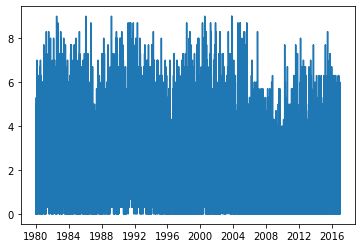

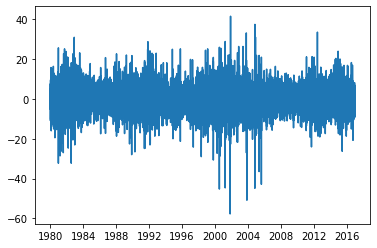

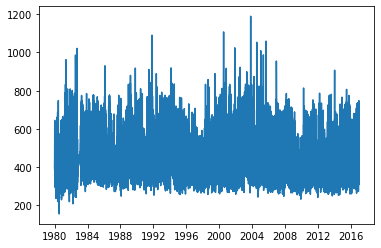

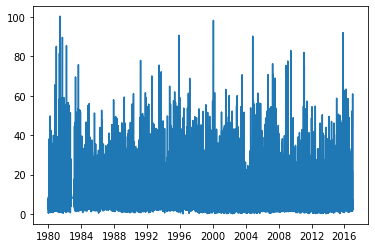

In [3]:
for d in (Kp, Bz, V, N):
    plt.figure()
    plt.plot(dates, d)

In [4]:
input_data = np.stack((Bz,V,N)).T
output_data = Kp[:,None]

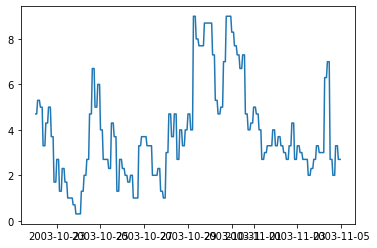

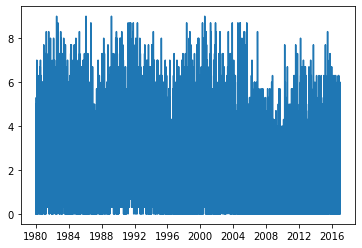

In [5]:
# Sélection d'une période de test:
from datetime import datetime
test_min, test_max = datetime(2003,10,22), datetime(2003,11,5)
in_test = np.logical_and(dates > test_min, dates < test_max)
train_index, = np.nonzero(np.logical_not(in_test))
test_index,  = np.nonzero(in_test)

X_train, X_test = input_data[train_index], input_data[test_index]
y_train, y_test = output_data[train_index], output_data[test_index]

plt.plot(dates[test_index], y_test)
plt.figure()
plt.plot(dates[train_index], y_train)

RMSE = 1.2300858790504017


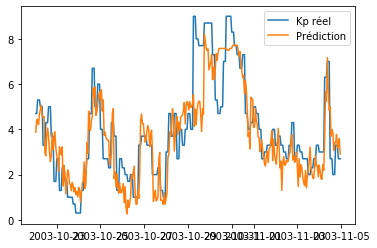

In [6]:
knn = neighbors.KNeighborsRegressor(10, weights='distance')
model = knn.fit(X_train, y_train)

p_test = model.predict(X_test)
plt.plot(dates[test_index], y_test)
plt.plot(dates[test_index], p_test)
plt.legend(("Kp réel", "Prédiction"))
print("RMSE =" , np.sqrt(mean_squared_error(y_test, p_test)))


(335, 1)


1.2300858790504017

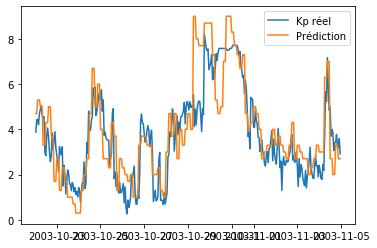

In [7]:
p_test = model.predict(X_test)
plt.plot(dates[test_index], p_test)
plt.plot(dates[test_index], y_test)
plt.legend(("Kp réel", "Prédiction"))
print(np.shape(p_test))
np.sqrt(mean_squared_error(y_test, p_test))

In [8]:

tss = TimeSeriesSplit(n_splits=100)
# Évaluation de l'erreur du model:
errors = []
m_dates = []
for train_index, test_index in tss.split(input_data, output_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = output_data[train_index], output_data[test_index]
    dates_test = dates[test_index]
    model = knn.fit(X_train, y_train)
    p_test = model.predict(X_test)
    error = np.sqrt(mean_squared_error(y_test, p_test))
    errors.append(error)
    m_dates.append(dates_test[len(test_index)//2])
    #plt.figure()
    #plt.plot(dates_test, y_test)
    #plt.plot(dates_test, p_test)


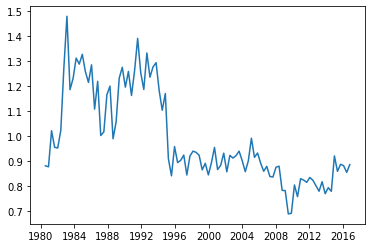

In [9]:
plt.plot(m_dates,errors)

# Évolution de l'erreur moyenne en fonction du temps. 
# En 1994/1995, deux nouveaux satellites (ACE,WIND) sont mis en services.
# Ce qui explique la forte baisse de l'erreur (moins de trous dans les données).

# 2. Support vector machine

## 2.1. SVR Linear 

In [10]:
# On change la période de données après la partie 1 parce qu'on sait la carence de ACE et WIND dans l'estimateur
ticks_change = spt.tickrange('1980-01-01T00:00:00', '2017-01-01T00:00:00', deltadays = 1./24.)
d1 = om.get_omni(ticks_change)

Kp1 = d1['Kp']
Bz1 = d1['BzIMF']
V1  = d1['velo']
N1  = d1['dens']
dates1 = d1['ticks'].UTC

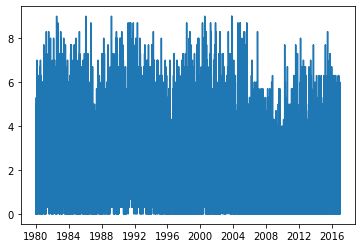

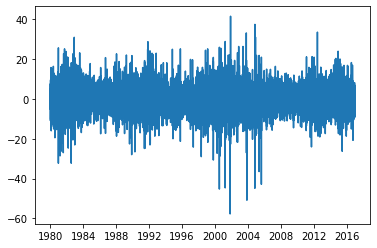

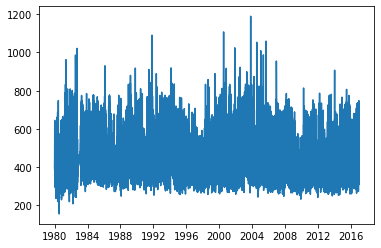

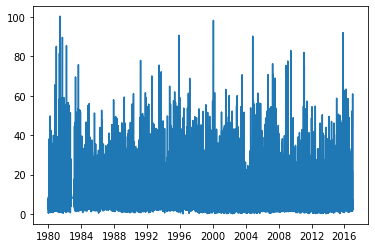

In [11]:
for d in (Kp1, Bz1, V1, N1):
    plt.figure()
    plt.plot(dates1, d)

In [12]:
input_data1 = np.stack((Bz1,V1,N1)).T
output_data1 = Kp1[:,None]

(335,)


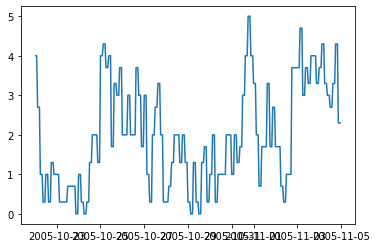

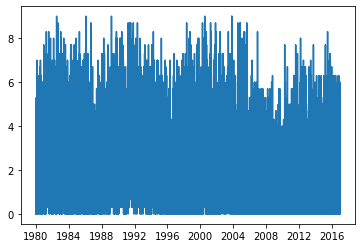

In [13]:
# Sélection d'une période de test:

test_min, test_max = datetime(2005,10,22), datetime(2005,11,5)
in_test = np.logical_and(dates1 > test_min, dates1 < test_max)
train_index, = np.nonzero(np.logical_not(in_test))
test_index,  = np.nonzero(in_test)

X_train1, X_test1 = input_data1[train_index], input_data1[test_index]
y_train1, y_test1 = output_data1[train_index], output_data1[test_index]

plt.plot(dates1[test_index], y_test1)
print(np.shape(dates1[test_index]))
plt.figure()
plt.plot(dates1[train_index], y_train1)

In [14]:
model_svm = svm.LinearSVR().fit(X_train1, y_train1.ravel())

C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RMSE: 1.714187818653699


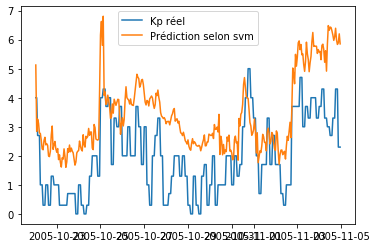

In [15]:
s_test = model_svm.predict(X_test1)
plt.plot(dates1[test_index], y_test1)
plt.plot(dates1[test_index], s_test)
plt.legend(("Kp réel", "Prédiction selon svm"))
print("RMSE:", np.sqrt(mean_squared_error(y_test1, s_test)))

In [16]:
tss = TimeSeriesSplit(n_splits=100)
# Évaluation de l'erreur du model:
errors = []
m_dates = []
for train_index, test_index in tss.split(input_data1, output_data1):
    X_train1, X_test1 = input_data1[train_index], input_data1[test_index]
    y_train1, y_test1 = output_data1[train_index], output_data1[test_index]
    dates_test = dates1[test_index]
    model_svm = svm.LinearSVR().fit(X_train1, y_train1.ravel())
    s_test = model_svm.predict(X_test1)
    error = np.sqrt(mean_squared_error(y_test1, s_test))
    errors.append(error)
    m_dates.append(dates_test[len(test_index)//2])
    #plt.figure()
    #plt.plot(dates_test, y_test)
    #plt.plot(dates_test, p_test)


C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

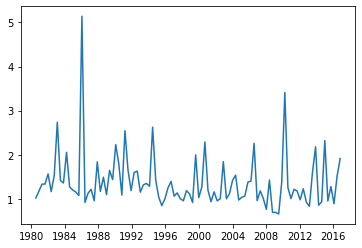

In [17]:
plt.plot(m_dates,errors)

## 2.2. SVR rbf ##

In [18]:
# On charge une bonne période de données
ticks = spt.tickrange('2012-01-01T00:00:00', '2017-01-01T00:00:00', deltadays = 1./24.)
d = om.get_omni(ticks)
Kp = d['Kp']
Bz = d['BzIMF']
V  = d['velo']
N  = d['dens']
dates = d['ticks'].UTC

In [19]:
input_data = np.stack((Bz,V,N)).T
output_data = Kp[:,None]

(23, 1)


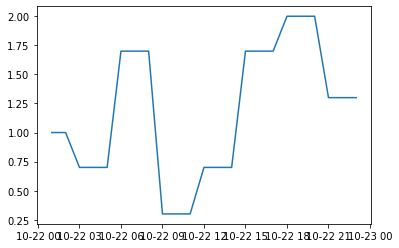

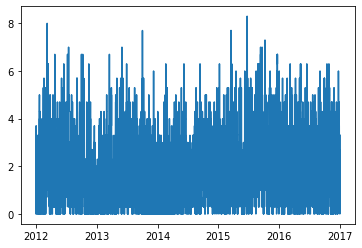

In [20]:
# Sélection d'une période de test:
from datetime import datetime
test_min, test_max = datetime(2015,10,22), datetime(2015,10,23)
in_test = np.logical_and(dates > test_min, dates < test_max)
train_index, = np.nonzero(np.logical_not(in_test))
test_index,  = np.nonzero(in_test)

X_train, X_test = input_data[train_index], input_data[test_index]
y_train, y_test = output_data[train_index], output_data[test_index]

plt.plot(dates[test_index], y_test)
print(np.shape(y_test))
plt.figure()
plt.plot(dates[train_index], y_train)


(23,)
(23, 1)
RMSE= 0.6457755144505566


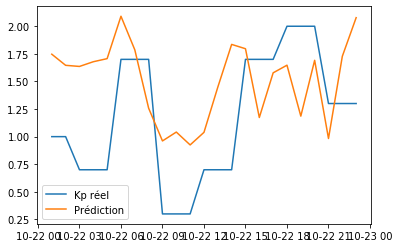

In [21]:
SVR = svm.SVR(kernel='rbf', tol=1e-5,cache_size=7000,gamma='scale')
model2 = SVR.fit(X_train, y_train.ravel())

pred = model2.predict(X_test)
plt.plot(dates[test_index], y_test)
plt.plot(dates[test_index], pred)
plt.legend(("Kp réel", "Prédiction"))
print(np.shape(pred))
print(np.shape(y_test))
print("RMSE=",np.sqrt(mean_squared_error(y_test, pred)))



(23,)
(23, 1)
RMSE= 0.6457755144505566


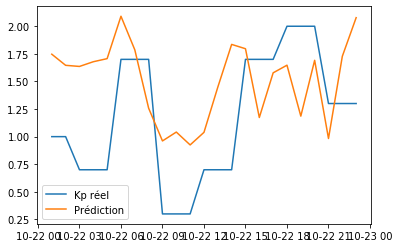

In [22]:
plt.plot(dates[test_index], y_test)
plt.plot(dates[test_index], pred)
plt.legend(("Kp réel", "Prédiction"))
print(np.shape(pred))
print(np.shape(y_test))
print("RMSE=",np.sqrt(mean_squared_error(y_test, pred)))

In [23]:

tss = TimeSeriesSplit(n_splits=1000)
# Évaluation de l'erreur du model:
errors = []
m_dates = []
for train_index, test_index in tss.split(input_data, output_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = output_data[train_index], output_data[test_index]
    dates_test = dates[test_index]
    model = knn.fit(X_train, y_train)
    p_test = model.predict(X_test)
    error = np.sqrt(mean_squared_error(y_test, p_test))
    errors.append(error)
    m_dates.append(dates_test[len(test_index)//2])
    #plt.figure()
    #plt.plot(dates_test, y_test)
    #plt.plot(dates_test, p_test)


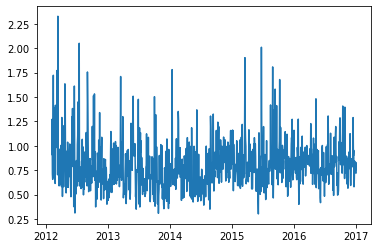

In [24]:
plt.plot(m_dates,errors)

# Évolution de l'erreur moyenne en fonction du temps. 
# En 1994/1995, deux nouveaux satellites (ACE,WIND) sont mis en services.
# Ce qui explique la forte baisse de l'erreur (moins de trous dans les données).

# 3. Decision Tree Learning

In [2]:
# On charge une bonne période de données
ticks = spt.tickrange('1980-01-01T00:00:00', '2017-01-01T00:00:00', deltadays = 1./24.)
d = om.get_omni(ticks)

Kp = d['Kp']
Bz = d['BzIMF']
V  = d['velo']
N  = d['dens']
dates = d['ticks'].UTC

In [3]:
input_data = np.stack((Bz,V,N)).T
output_data = Kp[:,None]

(335,)


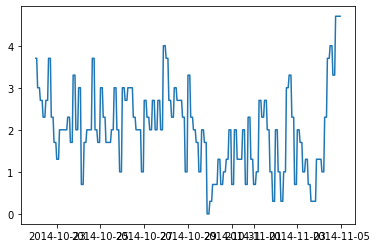

In [4]:
# Sélection d'une période de test:
from datetime import datetime
test_min, test_max = datetime(2014,10,22), datetime(2014,11,5)
in_test = np.logical_and(dates > test_min, dates < test_max)
train_index, = np.nonzero(np.logical_not(in_test))
test_index,  = np.nonzero(in_test)

X_train, X_test = input_data[train_index], input_data[test_index]
y_train, y_test = output_data[train_index], output_data[test_index]

plt.plot(dates[test_index], y_test)
print(np.shape(dates[test_index]))

## 3.1 Plot a tree

In [12]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_test,y_test )

In [13]:
dot_data=tree.export_graphviz(clf)
graph = graphviz.Source(dot_data)  

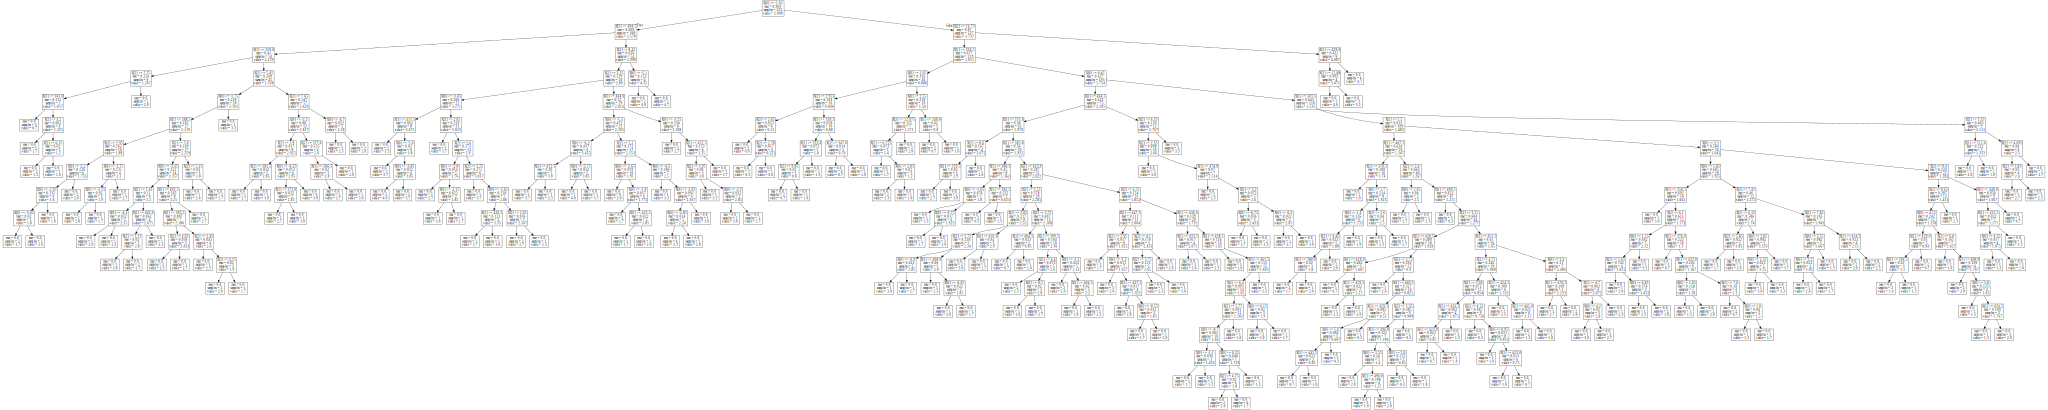

In [14]:
graph

## 3.2. Simulation

RMSE= 1.2225279657554977


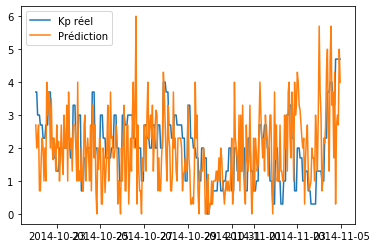

In [30]:
regr = tree.DecisionTreeRegressor()
model=regr.fit(X_train,y_train)
p_test = model.predict(X_test)
plt.plot(dates[test_index], y_test)
plt.plot(dates[test_index], p_test)
plt.legend(("Kp réel", "Prédiction"))
print("RMSE=", np.sqrt(mean_squared_error(y_test, p_test)))

In [31]:
tss = TimeSeriesSplit(n_splits=100)
# Évaluation de l'erreur du model:
errors = []
m_dates = []
for train_index, test_index in tss.split(input_data, output_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = output_data[train_index], output_data[test_index]
    dates_test = dates[test_index]
    model = regr.fit(X_train, y_train)
    p_test = model.predict(X_test)
    error = np.sqrt(mean_squared_error(y_test, p_test))
    errors.append(error)
    m_dates.append(dates_test[len(test_index)//2])
    #plt.figure()
    #plt.plot(dates_test, y_test)
    #plt.plot(dates_test, p_test)

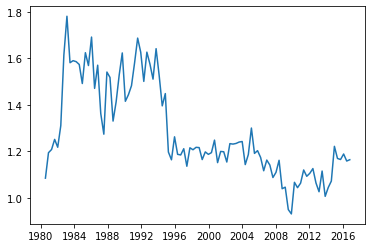

In [32]:
plt.plot(m_dates,errors)


# 4. Random Forest

In [33]:
# On charge une bonne période de données
ticks = spt.tickrange('1980-01-01T00:00:00', '2017-01-01T00:00:00', deltadays = 1./24.)
d = om.get_omni(ticks)

Kp = d['Kp']
Bz = d['BzIMF']
V  = d['velo']
N  = d['dens']
dates = d['ticks'].UTC

In [34]:
input_data = np.stack((Bz,V,N)).T
output_data = Kp[:,None]

(335,)


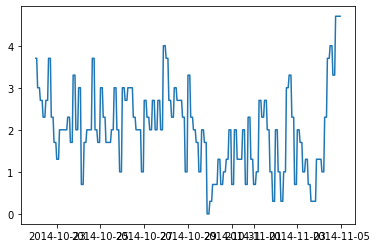

In [35]:
# Sélection d'une période de test:
from datetime import datetime
test_min, test_max = datetime(2014,10,22), datetime(2014,11,5)
in_test = np.logical_and(dates > test_min, dates < test_max)
train_index, = np.nonzero(np.logical_not(in_test))
test_index,  = np.nonzero(in_test)

X_train, X_test = input_data[train_index], input_data[test_index]
y_train, y_test = output_data[train_index], output_data[test_index]

plt.plot(dates[test_index], y_test)
print(np.shape(dates[test_index]))

RMSE=  0.9562193132512536


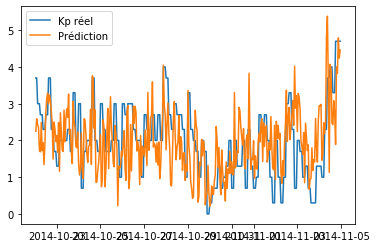

In [36]:
regr = RandomForestRegressor(random_state=1, n_estimators=10)
model=regr.fit(X_train, y_train.ravel())
p_test = model.predict(X_test)
plt.plot(dates[test_index], y_test)
plt.plot(dates[test_index], p_test)
plt.legend(("Kp réel", "Prédiction"))

print("RMSE= ",np.sqrt(mean_squared_error(y_test, p_test)))

In [37]:

tss = TimeSeriesSplit(n_splits=100)
# Évaluation de l'erreur du model:
errors = []
m_dates = []
for train_index, test_index in tss.split(input_data, output_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = output_data[train_index], output_data[test_index]
    dates_test = dates[test_index]
    model = regr.fit(X_train, y_train.ravel())
    p_test = model.predict(X_test)
    error = np.sqrt(mean_squared_error(y_test, p_test))
    errors.append(error)
    m_dates.append(dates_test[len(test_index)//2])
    #plt.figure()
    #plt.plot(dates_test, y_test)
    #plt.plot(dates_test, p_test)

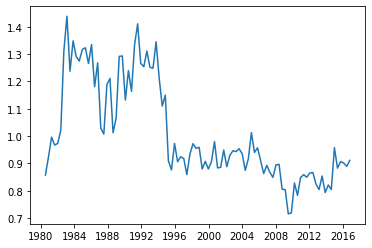

In [38]:
plt.plot(m_dates,errors)
